# Assignment 3

1. Implement Logistic Regression with Stochastic Gradient Decent using numpy
1. Implement Logistic Regression with early stopping using pytorch

Additional readings:
1. https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
1. https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# retrieve dataset
data = fetch_20newsgroups()


X_train = data['data']
y_train = data['target']

In [2]:
X_train[0], y_train[0]

("From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 7)

In [3]:
tfidf = TfidfVectorizer(max_df=0.5, min_df=10)
X_train = tfidf.fit_transform(X_train)

test_data = fetch_20newsgroups(subset='test')
X_test = tfidf.transform(test_data['data'])
y_test = test_data['target']

## 1 Binary Logistic Regression
$\{(x_i, y_i)\}_{i=1}^N$, $y \in \{0,1\}$
$$ z = Xw + b $$

$$p(y=1 | x) = \sigma(z) = \frac 1 {1 + e^{-z}}$$

$$ L_{batch} = - \frac 1 {|batch|} \sum_{i \in batch}^N [ y_i \log \sigma(z_i) + (1 - y_i) \log (1 - \sigma(z_i)) ] + \frac \lambda 2 w^T w$$

Stochastic Gradient Decent for logreg:
1. init w ~ random N(0,1), b = 0
1. for epoch = 1..n_epochs:
    * shuffle dataset
    * for every batch:
        * $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L_{batch}(w^{(t-1)},b^{(t-1)})$
        * $b^{(t)} \leftarrow b^{(t-1)} - \alpha \nabla_{b} L_{batch}(w^{(t-1)},b^{(t-1)})$
        
$w$ - weights  
$b$ - biases  
$\alpha$ - learning rate

Hint:
$$\nabla_w L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial w} + \frac {\partial (\frac \lambda 2 w^T w)} {\partial w} $$
$$\nabla_b L = \frac {\partial L} {\partial \sigma} \frac {\partial \sigma} {\partial z} \frac {\partial z} {\partial b} $$

In [4]:
# make dataset for binary classification

X_train_bin = X_train[y_train < 2]
y_train_bin = y_train[y_train < 2]

X_test_bin = X_test[y_test < 2]
y_test_bin = y_test[y_test < 2]

y_train_bin.shape, y_test_bin.shape

((1064,), (708,))

In [5]:
print(X_train_bin.shape)

(1064, 15566)


# Multinomial Logistic Regression using pytorch

auc 0.9968087935466714


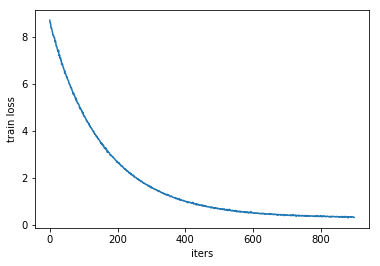

In [140]:
class LogRegNumpy(ClassifierMixin):
    def __init__(self, llambda=1, lr=0.1, batch_size=32, n_epochs=100):
        """
        llambda: regularization strength
        lr: learning rate
        """
        self.w = None
        self.b = 0
        self.llambda = llambda
        self.n_epochs = n_epochs
        self.lr = lr
        self.history = []
        self.batch_size = batch_size
        
    
    def fit(self, X, y):
        self.w = np.random.randn(X.shape[1])
        self.b = 0 
        
        for epoch in range(self.n_epochs):
            
            # random permutation over indices of dataset
            batch_indices = np.random.permutation(len(y))
            
            for j in range(0, len(y), self.batch_size):
                batch_idx = batch_indices[j:j+self.batch_size] # От нуля до 0+batch_size
                batch_X = X[batch_idx]
                batch_y = y[batch_idx]                
                #print('batch_X.shape: ', batch_X.shape, 'batch_y.shape: ', batch_y.shape)
            
                # forward pass
                # <TODO> [1 point] calculate batch loss                
                #print(self.w.shape, 'self.w befor T') Одно и то же дает при произведении       
                sigmoid = self.predict_proba(batch_X)            
                loss = ((-1/batch_X.shape[0]) 
                        * np.sum(batch_y * np.log(sigmoid) 
                                 + (1-batch_y)*np.log(1-sigmoid)) + (self.llambda/2)*self.w.T.dot(self.w))                
                #print('loss:', type(loss), loss)                
       
                
                # backward pass
                # <TODO> [2 points] calculate batch gradients 
                #print('batch_y_dim', batch_y.shape, 'sigm.shape', sigmoid.shape, 'batc_X.T', batch_X.T.shape)                
    
                grad_w = (1/batch_X.shape[0]) * batch_X.T * (sigmoid-batch_y) + self.llambda * self.w
                grad_b =  np.sum(sigmoid-batch_y) / batch_X.shape[0]
                #print('grad_w: ', type(grad_w), grad_w.shape)                
                #print('grad_b: ', type(grad_b), grad_b.shape)

                
                # SGD optimization step
                # <TODO> [1 point]
                self.w -=  self.lr * grad_w
                self.b -=  self.lr * grad_b                
                #print('self.w shape:', self.w.shape, 'self.b.shape', self.b.shape)
                
                self.history.append(loss)
        
        return self 
    
    def predict_proba(self, X):
        # <TODO> [1 point] calculate p(y=1 | x)
        z = X.dot(self.w) + self.b
        p = 1 /(1 + np.exp(-z)) 
        return p
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(np.int)
    
    
model = LogRegNumpy(llambda = 0.001, lr=3, batch_size=128, n_epochs=100)
model.fit(X_train_bin, y_train_bin)
print('auc', metrics.roc_auc_score(y_test_bin, model.predict_proba(X_test_bin)))

plt.plot(np.arange(len(model.history)), model.history)
plt.xlabel('iters')
plt.ylabel('train loss');

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

###  [1 point] implement linear model $Z = XW + b$

In [142]:
class LogRegNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super(LogRegNN, self).__init__()
        
        # create tensor of weights and tensor of biases
        # initialize tensors from N(0,1) 
        # W has shape (n_features, n_classes)
        # b has shape (n_classes,)
        self.W = nn.Parameter(torch.randn(n_features, n_classes))
        self.b = nn.Parameter(torch.randn(n_classes)) #теперь это вектор. (потому что они будут изменяться иначе одинакого) 
        
    def forward(self, x):
        """
        In this method we implement connections between neural network weights
        x: batch feature matrix
        returns: probability logits
        """
        # <TODO> implement linear model #перемножаем две матрицы, прибавляем вектор
        result =  torch.mm(x,self.W) + self.b
        return result

In [143]:
def train_batch(model, batch_x, batch_y):
    # set NN model in training mode
    model.train()
    
    # zero gradients
    optimizer.zero_grad()
    # forward pass
    pred = model(batch_x)
    # cross-entropy loss
    loss = criterion(pred, batch_y)
    # calculate gradients
    loss.backward()
    # make optimization step
    optimizer.step()
    
    # return batch loss
    return loss.data.detach().item()

def eval_batch(model, batch_x, batch_y):
    # set NN model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # forward pass
        pred = model(batch_x)
        # cross-entropy loss
        loss = criterion(pred, batch_y)

    # return batch loss
    return loss.data.item()

### [2 points] implement early stopping using early_stopping_patience

In [144]:
def train(model, train_loader, valid_loader, n_epochs, early_stopping_patience=5): #esp - сколько эпох надо смотреть на увеличение ошибки при обучении прежде чем обрубить
    """
    early_stopping_patience - number of consecutive epochs of growing validation loss to wait
    """
    history = {'train': [], 'valid': []}

    # <TODO> implement early stopping using early_stopping_patience
    
    count_e_stopping = 0
    for epoch in range(n_epochs):
        epoch_train_loss = 0
        
        # iterate over batches
        for batch_x, batch_y in tqdm(train_loader, desc=f'epoch:{epoch}', leave=True):

            loss = train_batch(model, batch_x, batch_y)
            epoch_train_loss += loss

        # average loss for epoch
        epoch_train_loss /= len(train_loader)
        history['train'].append(epoch_train_loss)
        
        epoch_valid_loss = 0
        for batch_x, batch_y in valid_loader:
            loss = eval_batch(model, batch_x, batch_y)
            epoch_valid_loss += loss
            
        epoch_valid_loss /= len(valid_loader)
        print(f'train loss: {epoch_train_loss:.3f} valid loss:{epoch_valid_loss:.3f}')
        history['valid'].append(epoch_valid_loss)
        
        # <TODO> implement early stopping using early_stopping_patience
        if epoch > early_stopping_patience:
            if epoch_valid_loss > history['valid'][-2]:
                count_e_stopping += 1
                if count_e_stopping == early_stopping_patience:
                        print('Early Stopping!')
                        return history
            else:
                count_e_stopping = 0         
        
            

    return history 

### predict hard labels [1 point]

In [145]:
def predict(model, test_loader):
    
    model.eval()
    
    result = []
    with torch.no_grad():
        for batch_x in test_loader:
            # <TODO> predict hard labels
            pred = model(batch_x)
            #print('pred', type(pred), pred.size()) #Т.е. нам нужен индекс максимального класса
            hard_label_pred = torch.argmax(pred, dim=1)
            result.append(hard_label_pred)
    return np.concatenate(result)

DataLoader implements iteration over batches and shuffling

L2 regularization coef is embedded into SGD.weight_decay: 

1. $w^{(t-1)} \leftarrow w^{(t-2)} - \alpha \lambda w^{(t-2)} $  
1. $w^{(t)} \leftarrow w^{(t-1)} - \alpha \nabla_{w} L(w^{(t-1)}) $

here   
$\alpha$ - learning rate  
$\lambda$ - weight-decay = L2 regularization coef

In [146]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train, y_train, stratify=y_train,
                                                      shuffle=True, test_size=0.2, random_state=42)

batch_size = 256


train_loader = DataLoader(TensorDataset(torch.tensor(X_train2.todense()).float(), torch.tensor(y_train2).long()), 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid2.todense()).float(), torch.tensor(y_valid2).long()), 
                          batch_size=batch_size)
test_loader = DataLoader(torch.tensor(X_test.todense()).float(), 
                          batch_size=batch_size)

model = LogRegNN(X_train.shape[1], 20)

criterion = nn.CrossEntropyLoss()
# L2 regularization is embeded in 
optimizer = optim.SGD(model.parameters(), lr=10.0, weight_decay=0.0001) #w_decay = коэфф при l2 реагулир

history = train(model, train_loader, valid_loader, 100, 2)


train loss: 3.218 valid loss:2.979



train loss: 2.794 valid loss:2.641



train loss: 2.450 valid loss:2.383



train loss: 2.176 valid loss:2.152



train loss: 1.951 valid loss:1.972



train loss: 1.770 valid loss:1.845



train loss: 1.621 valid loss:1.705



train loss: 1.498 valid loss:1.596



train loss: 1.393 valid loss:1.510



train loss: 1.306 valid loss:1.441



train loss: 1.233 valid loss:1.383



train loss: 1.171 valid loss:1.336



train loss: 1.120 valid loss:1.288



train loss: 1.069 valid loss:1.249



train loss: 1.031 valid loss:1.222



train loss: 0.995 valid loss:1.190



train loss: 0.966 valid loss:1.167



train loss: 0.935 valid loss:1.142



train loss: 0.911 valid loss:1.117



train loss: 0.887 valid loss:1.112



train loss: 0.873 valid loss:1.087



train loss: 0.853 valid loss:1.074



train loss: 0.840 valid loss:1.065



train loss: 0.825 valid loss:1.053



train loss: 0.813 valid loss:1.039



train loss: 0.802 valid loss:1.034



train loss: 0.790 valid loss:1.019



train loss: 0.782 valid loss:1.017



train loss: 0.773 valid loss:1.011



train loss: 0.765 valid loss:1.008



train loss: 0.758 valid loss:0.997



train loss: 0.753 valid loss:0.994



train loss: 0.746 valid loss:0.993



train loss: 0.740 valid loss:0.985



train loss: 0.734 valid loss:0.981



train loss: 0.732 valid loss:0.980



train loss: 0.730 valid loss:0.976



train loss: 0.725 valid loss:0.973



train loss: 0.722 valid loss:0.966



train loss: 0.716 valid loss:0.976



train loss: 0.714 valid loss:0.969



train loss: 0.713 valid loss:0.967



train loss: 0.709 valid loss:0.960



train loss: 0.708 valid loss:0.963



train loss: 0.704 valid loss:0.961



train loss: 0.702 valid loss:0.958



train loss: 0.701 valid loss:0.957



train loss: 0.699 valid loss:0.956



train loss: 0.699 valid loss:0.956



train loss: 0.699 valid loss:0.957
Early Stopping!


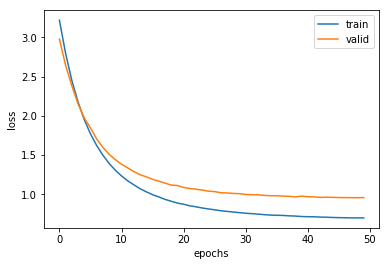

In [147]:
plt.plot(np.arange(len(history['train'])), history['train'], label='train')
plt.plot(np.arange(len(history['valid'])), history['valid'], label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [148]:
y_pred = predict(model, test_loader)
metrics.accuracy_score(y_test, y_pred)

0.7991237387148168

### What is the cross-entropy loss of uniformly random guessing classifier for this task? [0.5 point]

In [149]:
#criterion = nn.CrossEntropyLoss()
y_random = torch.rand((y_test.shape[0], len(np.unique(y_pred))))
criterion(y_random, torch.tensor(y_pred))

tensor(3.0346)

### What is the accuracy of constant prediction classifier for this task? [0.5 point]

Если у нас сбалансированный датасет, то примерно 1/n, где n - количество классов. Если не сбалансированный - то accuracy будет пропорционален кол-ву объектов класса, метку которого мы выбрали как константное предсказание.

In [150]:
for i in range(0, len(np.unique(y_pred))):
    y_pred_const = np.array([i]*len(y_test))
    print('Accuracy for class {} : {}'.format(i, metrics.accuracy_score(y_test, y_pred_const)))

Accuracy for class 0 : 0.042352628783855546
Accuracy for class 1 : 0.05164630908125332
Accuracy for class 2 : 0.0523101433882103
Accuracy for class 3 : 0.05204460966542751
Accuracy for class 4 : 0.05111524163568773
Accuracy for class 5 : 0.0524429102496017
Accuracy for class 6 : 0.05177907594264471
Accuracy for class 7 : 0.0525756771109931
Accuracy for class 8 : 0.05284121083377589
Accuracy for class 9 : 0.05270844397238449
Accuracy for class 10 : 0.05297397769516728
Accuracy for class 11 : 0.0525756771109931
Accuracy for class 12 : 0.052177376526818905
Accuracy for class 13 : 0.0525756771109931
Accuracy for class 14 : 0.0523101433882103
Accuracy for class 15 : 0.05284121083377589
Accuracy for class 16 : 0.048327137546468404
Accuracy for class 17 : 0.04992033988316516
Accuracy for class 18 : 0.041157727031332976
Accuracy for class 19 : 0.03332448220924057
